In [1]:
from pathlib import Path
import logging
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


In [23]:
# Functions to use here:
# - calcuate annual mean from monthly means, weighted by days-in-month
# - spatial average, weighted, missing values ok
# - masking ocean/ice .... this one custom for ERA5 where we need ice & land-sea mask

# from ADF
def annual_mean(data, whole_years=False, time_name='time'):
    """Calculate annual averages from monthly time series data.

    Parameters
    ----------
    data : xr.DataArray or xr.Dataset
        monthly data values with temporal dimension
    whole_years : bool, optional
        whether to restrict endpoints of the average to
        start at first January and end at last December
    time_name : str, optional
        name of the time dimension, defaults to `time`

    Returns
    -------
    result : xr.DataArray or xr.Dataset
        `data` reduced to annual averages

    Notes
    -----
    This function assumes monthly data, and weights the average by the
    number of days in each month.

    `result` includes an attribute that reports the date range used for the average.
    """
    assert time_name in data.coords, f"Did not find the expected time coordinate '{time_name}' in the data"
    if whole_years:
        first_january = np.argwhere((data.time.dt.month == 1).values)[0].item()
        last_december = np.argwhere((data.time.dt.month == 12).values)[-1].item()
        data_to_avg = data.isel(time=slice(first_january,last_december+1)) # PLUS 1 BECAUSE SLICE DOES NOT INCLUDE END POINT
    else:
        data_to_avg = data
    date_range_string = f"{data_to_avg['time'][0]} -- {data_to_avg['time'][-1]}"

    # this provides the normalized monthly weights in each year
    # -- do it for each year to allow for non-standard calendars (360-day)
    # -- and also to provision for data with leap years
    days_gb = data_to_avg.time.dt.daysinmonth.groupby('time.year').map(lambda x: x / x.sum())
    # weighted average with normalized weights: <x> = SUM x_i * w_i  (implied division by SUM w_i)
    result =  (data_to_avg * days_gb).groupby('time.year').sum(dim='time')
    result.attrs['averaging_period'] = date_range_string
    return result

# Modified from ADF (remove ADF-specific code)
def spatial_average(indata, weights=None, spatial_dims=None):
    """Compute spatial average.

    Parameters
    ----------
    indata : xr.DataArray
        input data
    weights : np.ndarray or xr.DataArray, optional
        the weights to apply, see Notes for default behavior
    spatial_dims : list, optional
        list of dimensions to average, see Notes for default behavior

    Returns
    -------
    xr.DataArray
        weighted average of `indata`

    Notes
    -----
    When `weights` is not provided, tries to find sensible values.
    If there is a 'lat' dimension, use `cos(lat)`.
    If there is a 'ncol' dimension, looks for `area` in `indata`.
    Otherwise, set to equal weights.

    Makes an attempt to identify the spatial variables when `spatial_dims` is None.
    Will average over `ncol` if present, and then will check for `lat` and `lon`.
    When none of those three are found, raise an AdfError.
    """
    if weights is None:
        #Calculate spatial weights:
        if 'lat' in indata.coords:
            weights = np.cos(np.deg2rad(indata.lat))
            weights.name = "weights"
        elif 'ncol' in indata.dims:
            if 'area' in indata:
                warnings.warn("area variable being used to generated normalized weights.")
                weights = indata['area'] / indata['area'].sum()
            else:
                warnings.warn("We need a way to get area variable. Using equal weights.")
                weights = xr.DataArray(1.)
            weights.name = "weights"
        else:
            weights = xr.DataArray(1.)
            weights.name = "weights"
            warnings.warn("Un-recognized spatial dimensions: using equal weights for all grid points.")
        #End if
    #End if

    #Apply weights to input data:
    weighted = indata.weighted(weights)

    # we want to average over all non-time dimensions
    if spatial_dims is None:
        if 'ncol' in indata.dims:
            spatial_dims = ['ncol']
        else:
            spatial_dims = [dimname for dimname in indata.dims if (('lat' in dimname.lower()) or ('lon' in dimname.lower()))]

    if not spatial_dims:
        #Scripts using this function likely expect the horizontal dimensions
        #to be removed via the application of the mean. So in order to avoid
        #possibly unexpected behavior due to arrays being incorrectly dimensioned
        #(which could be difficult to debug) the ADF should die here:
        emsg = "spatial_average: No spatial dimensions were identified,"
        emsg += " so can not perform average."
        raise ValueError(emsg)

    return weighted.mean(dim=spatial_dims)




def mask_ocean_ice(arr, ocn, ice):
    """Given data, arr, and ocean fraction, ocn, and sea-ice cover, ice, 
       return the data where ocean > 0.9 and ice < 0.1
    """
    arr = xr.where((ocn<=0.9)&(ice<=0.1), arr, np.nan)
    arr.attrs["missing_value"] = np.nan
    return(arr)


In [28]:
# grib file example

# NOTE: you need cfgrib installed:
# conda install cfgrib 

grb_ex = "/glade/campaign/collections/rda/data/ds633.1/e5.moda.an.sfc/1979/e5.moda.an.sfc.128_034_sstk.ll025sc.1979010100_1979120100.grb"
grb_ds = xr.load_dataset(sst_ex, engine="cfgrib")


ValueError: unrecognized engine cfgrib must be one of: ['netcdf4', 'h5netcdf', 'scipy', 'gini', 'store']

In [7]:
# netCDF EXAMPLE

# Some of the ERA5 data on RDA is converted to netCDF

# The rest of the notebook just uses the netCDF files. 

ds = xr.open_dataset("/glade/campaign/collections/rda/data/ds633.1/e5.moda.an.sfc/1979/e5.moda.an.sfc.128_034_sstk.ll025sc.1979010100_1979120100.nc")

ds2 = xr.open_dataset("/glade/campaign/collections/rda/data/ds633.1/e5.moda.an.sfc/1979/e5.moda.an.sfc.128_031_ci.ll025sc.1979010100_1979120100.nc")

ds3 = xr.open_dataset("/glade/campaign/collections/rda/data/ds633.1/e5.moda.an.sfc/1979/e5.moda.an.sfc.128_172_lsm.ll025sc.1979010100_1979120100.nc")

# the land-sea mask ("LSM") is 0 for all ocean and 1 for all land... looks like "lake" reduces the value
# sea ice doesn't seem to be a factor

In [13]:
ds2['CI']

<xarray.DataArray 'CI' (time: 12, latitude: 721, longitude: 1440)>
[12458880 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 1979-12-01
Attributes: (12/14)
    long_name:                     Sea-ice cover
    short_name:                    ci
    units:                         (0-1)
    original_format:               WMO GRIB 1 with ECMWF local table
    ecmwf_local_table:             128
    ecmwf_parameter:               31
    ...                            ...
    grid_specification:            0.25 degree x 0.25 degree from 90N to 90S ...
    rda_dataset:                   ds633.1
    rda_dataset_url:               https:/rda.ucar.edu/datasets/ds633.1/
    rda_dataset_doi:               DOI: 10.5065/P8GT-0R61
    rda_dataset_group:             ERA5 monthly mean atmospheric surface anal...
    number_of_significant_digits:  7

In [21]:
# how to mask ocean and ice
tst_ocn = mask_ocean_ice(ds['SSTK'], ds3['LSM'], ds2['CI'])

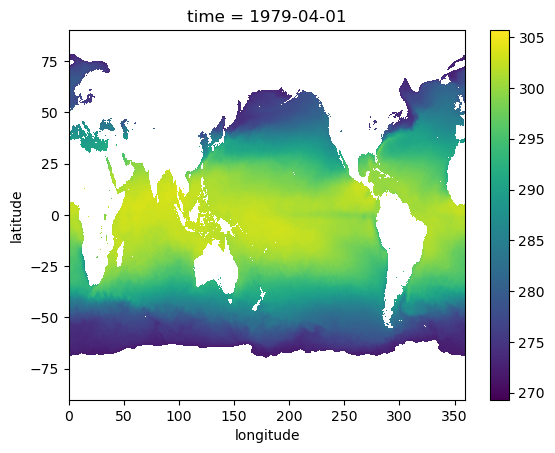

In [22]:
tst_ocn.isel(time=3).plot.pcolormesh()

In [32]:
# Area-weighted global average

if "latitude" in tst_ocn.dims:
    tst_ocn = tst_ocn.rename({"latitude":"lat", "longitude":"lon"})
area_weight = np.cos(np.radians(tst_ocn.lat))

tst_ocn_globalaverage = spatial_average(tst_ocn, weights=area_weight)
tst_ocn_globalaverage

<xarray.DataArray (time: 12)>
array([292.54490171, 292.5614533 , 292.6804136 , 292.80139705,
       292.76394446, 292.87897235, 292.88247576, 292.87231806,
       292.77457963, 292.68204638, 292.66169859, 292.61598599])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 1979-12-01

In [30]:
# demonstrate annual average:
tst_ocn_ann_global = annual_mean(tst_ocn_globalaverage)
tst_ocn_ann_global

<xarray.DataArray (year: 1)>
array([292.72746517])
Coordinates:
  * year     (year) int64 1979
Attributes:
    averaging_period:  <xarray.DataArray 'time' ()>\narray('1979-01-01T00:00:...

In [59]:
# TIME SERIES EXAMPLE

# most of the work now is just dealing with the paths
start_year = 1979
end_year = 2000

stem = Path("/glade/campaign/collections/rda/data/ds633.1/e5.moda.an.sfc")
sst_fils = []
ice_fils = []
lsm_fils = []
for y in range(start_year, end_year+1):
    sst_fils.append( stem / str(y) / f"e5.moda.an.sfc.128_034_sstk.ll025sc.{y}010100_{y}120100.nc")
    ice_fils.append( stem / str(y) / f"e5.moda.an.sfc.128_031_ci.ll025sc.{y}010100_{y}120100.nc")
    lsm_fils.append( stem / str(y) / f"e5.moda.an.sfc.128_172_lsm.ll025sc.{y}010100_{y}120100.nc")

sst_ds = xr.open_mfdataset(sst_fils)
ice_ds = xr.open_mfdataset(ice_fils)
lsm_ds = xr.open_mfdataset(lsm_fils)
# NOTE: these will be lazy loaded
#  -> good b/c they're going to be big
# -> bad b/c you'll need to be careful about when to do "compute()"

In [60]:
if "latitude" in sst_ds.dims:
    sst_ds = sst_ds.rename({"latitude":"lat", "longitude":"lon"})
    ice_ds = ice_ds.rename({"latitude":"lat", "longitude":"lon"})
    lsm_ds = lsm_ds.rename({"latitude":"lat", "longitude":"lon"})
    

In [61]:
area_weight = np.cos(np.radians(sst_ds.lat))

In [62]:
%%time
sst_masked = mask_ocean_ice(sst_ds['SSTK'], lsm_ds['LSM'], ice_ds['CI']).compute()


CPU times: user 11.6 s, sys: 2.06 s, total: 13.7 s
Wall time: 11.7 s


In [63]:
%%time
result = annual_mean(spatial_average(sst_masked, weights=area_weight, spatial_dims=("lat","lon")))

CPU times: user 1.59 s, sys: 268 ms, total: 1.86 s
Wall time: 1.86 s


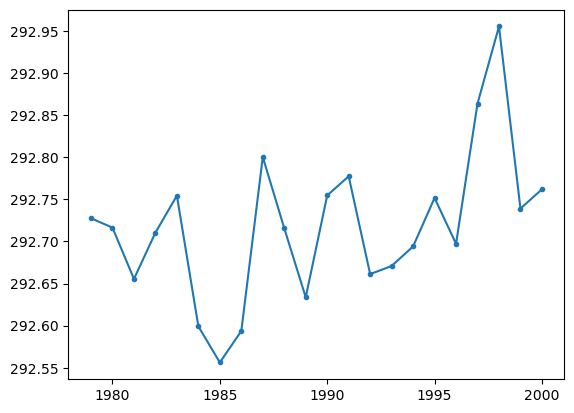

In [64]:
plt.plot(result.year, result, marker='.')